# Subset Simulation for a SDOF resonance problem
Michael D. Shields<br>
Johns Hopkins University<br>
11/3/18

Here, the Modified Metropolis Hastings Algorithm for MCMC is compared to the Affine Invariant Ensemble sampler for MCMC in subset simulation to estimate probability of failure of a single degree of freedom system subjected to harmonic excitation with a given frequency. 

In [1]:
from UQpy.reliability import SubsetSimulation
from UQpy.RunModel import RunModel
from UQpy.sampling import MmhInput,StretchInput, Stretch, ModifiedMetropolisHastings, MonteCarloSampling
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
from Resonance_pfn import RunPythonModel
from UQpy.distributions import Normal, JointIndependent, MultivariateNormal

## Problem Definition
A stochastic single degree of freedom system having stiffness $k\sim N(\mu_k,\sigma_k)$ and mass $m\sim N(\mu_m,\sigma_m)$ is excited by a sinusoidal load with frequency $\omega \text{rad/sec}$. The system is undamped and has equation of motion given by:

$m\ddot{u}+ku=sin(\omega t)$

Resonance occurs when the natural frequency of the system $\omega_n=\sqrt{\dfrac{k}{m}}=\omega\text{ rad/sec}$. To avoid resonance, we consider failure of the system to be associated with the natural frequecy being within a threshold, $\epsilon$ of the excitation frequency $\omega$. That is, failure of the system occurs when $\omega-\epsilon\le\sqrt{\dfrac{k}{m}}\le\omega+\epsilon$.

Here, we use subset simulation to evaluate the probability of failure given by:

$P\left(\omega-\epsilon\le\sqrt{\dfrac{k}{m}}\le\omega+\epsilon\right)=P\left(k-(\omega-\epsilon)^2m\le0 \cup (\omega+\epsilon)^2m-k\le 0\right)$

## Set Parameters
$\omega=5$<br>
$\epsilon = 0.0001$<br>
$\mu_k=125$<br>
$\sigma_k=20$<br>
$\mu_m=5$<br>
$\sigma_m=1$<br>

In [2]:
omega = 6
epsilon = 0.0001
mu_m = 5
sigma_m = 1
mu_k = 125
sigma_k = 20
m = np.linspace(mu_m - 3 * sigma_m, mu_m + 3 * sigma_m, 101)
k_hi = (omega - epsilon) ** 2 * m
k_lo = (omega + epsilon) ** 2 * m

Plot the failure domain

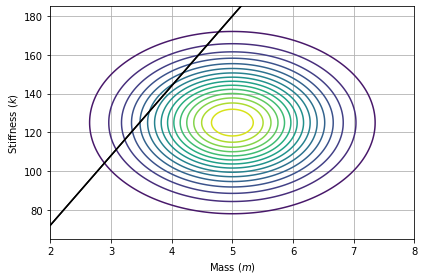

In [3]:
x = np.linspace(2, 8, 1000)
y = np.linspace(25, 225, 1000)

X, Y = np.meshgrid(x, y)
Z = np.zeros((1000, 1000))

d1 = Normal(loc=5, scale=1)
d2 = Normal(loc=125, scale=20)

dist = JointIndependent(marginals=[d1, d2])

for i in range(len(x)):
    Z[i, :] = dist.pdf(np.append(np.atleast_2d(X[i, :]), np.atleast_2d(Y[i, :]), 0).T)

fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z, 15)
plt.plot(m, k_hi, 'k')
plt.plot(m, k_lo, 'k')
# plt.fill_between(m,k_lo,k_hi)
plt.xlim([mu_m - 3 * sigma_m, mu_m + 3 * sigma_m])
plt.ylim([mu_k - 3 * sigma_k, mu_k + 3 * sigma_k])
plt.xlabel(r'Mass ($m$)')
plt.ylabel(r'Stiffness ($k$)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Resonance_pdf.pdf')
plt.show()

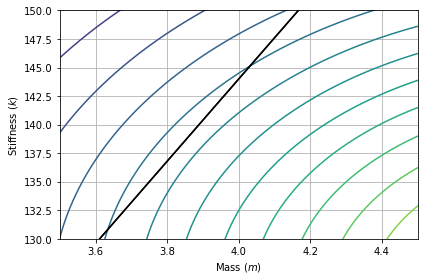

In [4]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z, 15)
plt.plot(m, k_hi, 'k')
plt.plot(m, k_lo, 'k')
# plt.fill_between(m,k_lo,k_hi)
plt.xlim([3.5, 4.5])
plt.ylim([130, 150])
plt.xlabel(r'Mass ($m$)')
plt.ylabel(r'Stiffness ($k$)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Resonance_pdf_zoom.pdf')
plt.show()

In [5]:
model = RunModel(model_script='Resonance_pfn.py', model_object_name="RunPythonModel", ntasks=1)

## Monte Carlo Simulation

In [6]:
x_mcs = MonteCarloSampling(distributions=[d1, d2])
x_mcs.run(samples_number=1000000)

In [7]:
model.run(samples=x_mcs.samples)

In [8]:
A = np.asarray(model.qoi_list) < 0
pf = np.shape(np.asarray(model.qoi_list)[np.asarray(model.qoi_list) < 0])[0] / 1000000
print(pf)

2.8e-05


In [9]:
ntrials = 1
pf_stretch = np.zeros((ntrials, 1))
cov1_stretch = np.zeros((ntrials, 1))
cov2_stretch = np.zeros((ntrials, 1))
m = np.ones(2)
m[0] = 5
m[1] = 125
C = np.eye(2)
C[0, 0] = 1
C[1, 1] = 20 ** 2

for i in range(ntrials):
    model = RunModel(model_script='Resonance_pfn.py', model_object_name="RunPythonModel", ntasks=1)
    dist = MultivariateNormal(mean=m, cov=C)
    xx = dist.rvs(nsamples=1000, random_state=123)
    xx1 = dist.rvs(nsamples=100, random_state=123)

    input=StretchInput(dimension=2, chains_number=100, log_pdf_target=dist.log_pdf)
    x_ss_stretch = SubsetSimulation(mcmc_input=input, runmodel_object=model, conditional_probability=0.1,
                                    samples_number_per_subset=1000, samples_init=xx, )

    pf_stretch[i] = x_ss_stretch.pf
    cov1_stretch[i] = x_ss_stretch.cov1
    cov2_stretch[i] = x_ss_stretch.cov2

In [10]:
print(pf_stretch)
print(np.mean(pf_stretch, 0))
b_stretch = -stats.norm.ppf(pf_stretch)
print(np.mean(b_stretch, 0))
print(stats.variation(b_stretch))

[[0.]]
[0.]
[inf]
[nan]


/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


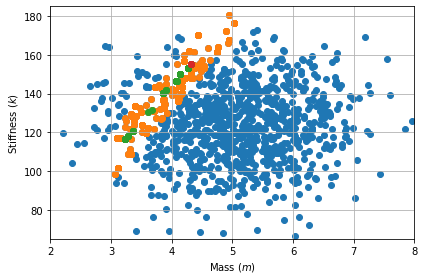

In [11]:
for i in range(len(x_ss_stretch.g)):
    plt.scatter(x_ss_stretch.samples[i][:, 0], x_ss_stretch.samples[i][:, 1], marker='o')

plt.xlim([mu_m - 3 * sigma_m, mu_m + 3 * sigma_m])
plt.ylim([mu_k - 3 * sigma_k, mu_k + 3 * sigma_k])
plt.xlabel(r'Mass ($m$)')
plt.ylabel(r'Stiffness ($k$)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Resonance_Stretch.pdf')
plt.show()

In [12]:
ntrials = 100
pf_mmh = np.zeros((ntrials, 1))
cov1_mmh = np.zeros((ntrials, 1))
cov2_mmh = np.zeros((ntrials, 1))
m = np.ones(2)
m[0] = 5
m[1] = 125
C = np.eye(2)
C[0, 0] = 1
C[1, 1] = 20 ** 2

for i in range(ntrials):
    model = RunModel(model_script='Resonance_pfn.py', model_object_name="RunPythonModel", ntasks=1)
    dist = MultivariateNormal(mean=m, cov=C)
    xx = dist.rvs(nsamples=1000, random_state=123)
    xx1 = dist.rvs(nsamples=100, random_state=123)

    input = MmhInput(dimension=2, chains_number=100, log_pdf_target=dist.log_pdf)
    x_ss_mmh = SubsetSimulation(mcmc_input=input, runmodel_object=model, conditional_probability=0.1,
                                samples_number_per_subset=1000, samples_init=xx)

    pf_mmh[i] = x_ss_mmh.pf
    cov1_mmh[i] = x_ss_mmh.cov1
    cov2_mmh[i] = x_ss_mmh.cov2

In [13]:
pf_mmh[pf_mmh == 0] = 1e-100
print(np.mean(pf_mmh, 0))
b_mmh = -stats.norm.ppf(pf_mmh)
print(np.mean(b_mmh, 0))
print(stats.variation(b_mmh))

[1.e-100]
[21.27345356]
[1.67002206e-16]


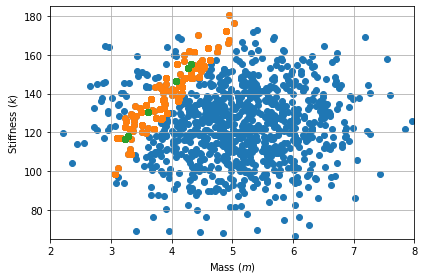

In [14]:
for i in range(len(x_ss_mmh.g)):
    plt.scatter(x_ss_mmh.samples[i][:, 0], x_ss_mmh.samples[i][:, 1], marker='o')

plt.xlim([mu_m - 3 * sigma_m, mu_m + 3 * sigma_m])
plt.ylim([mu_k - 3 * sigma_k, mu_k + 3 * sigma_k])
plt.xlabel(r'Mass ($m$)')
plt.ylabel(r'Stiffness ($k$)')
plt.grid(True)
plt.tight_layout()
plt.savefig('Resonance_MMH.pdf')
plt.show()